# Data
- Occupations by State and Likelihood of Automation: https://data.world/wnedds/occupations-by-state-and-likelihood-of-automation
- Wage by Occupation: https://data.world/quanticdata/occupation-and-salary-by-state-and-likelihood-of-automation/workspace/file?filename=national_M2016_dl.xlsx

# Data Handling (ingestion/cleaning/creation)

In [67]:
import pandas as pd
import seaborn as sns
import numpy as np
import patsy
from scipy.stats import normaltest
import statsmodels.api as sm

In [27]:
df_occ = pd.read_csv('../datasets/raw_state_automation_data.csv', encoding='cp1252')
df_wages = pd.read_excel('../datasets/wagedata.xlsx')

In [28]:
df_wages.head()

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,00-0000,All Occupations,total,140400040,0.1,23.86,49630,0.1,9.27,11.6,17.81,28.92,45.45,19290,24140,37040,60150,94540,NaN,NaN
1,11-0000,Management Occupations,major,7090790,0.2,56.74,118020,0.1,22.76,32.99,48.46,70.72,#,47330,68630,100790,147090,#,NaN,NaN
2,11-1000,Top Executives,minor,2465800,0.2,61.03,126950,0.2,20.58,31.45,49.19,78.35,#,42810,65420,102320,162970,#,NaN,NaN
3,11-1010,Chief Executives,broad,223260,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN
4,11-1011,Chief Executives,detailed,223260,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN


In [29]:
df_occ = df_occ[['SOC', 'Occupation', 'Probability']]

In [30]:
df = pd.merge(df_occ, df_wages, how='left', left_on='SOC', right_on='OCC_CODE')

In [32]:
df.head()

,SOC,Occupation,Probability,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,11-1011,Chief Executives,0.015,223260.0,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN
1,11-1021,General and Operations Managers,0.160,2188870.0,0.3,58.7,122090,0.2,21.29,31.2,47.74,74.53,#,44290,64890,99310,155020,#,NaN,NaN
2,11-2011,Advertising and Promotions Managers,0.039,28860.0,2.3,56.64,117810,1.5,21.61,32.21,48.47,70.98,#,44950,67000,100810,147640,#,NaN,NaN
3,11-2021,Marketing Managers,0.014,205900.0,1.0,69.3,144140,0.5,32.45,44.81,63.07,85.91,#,67490,93200,131180,178690,#,NaN,NaN
4,11-2022,Sales Managers,0.013,365230.0,0.6,64.95,135090,0.3,26.82,38.18,56.71,80.91,#,55790,79420,117960,168300,#,NaN,NaN


In [49]:
# See what we're dealing with
df.A_MEAN.unique()

array([194350., 122090., 117810., 144140., 135090., 123360.,  98930.,
       145740., 139720., 107060., 117720.,  97630., 126900., 120210.,
       115180.,  75790.,  99510.,  52150.,  95390., 105770., 143870.,
        56010.,  79690.,  59410., 109370., 136150.,  71980.,  70290.,
        70870.,  78060., 112150.,  86560.,  63910.,  60040.,  67420.,
        64990.,  65930.,  70250.,  66620.,  47290.,     nan,  77810.,
        91910.,  52020.,  66490.,  63350.,  70620.,  74870.,  76730.,
        58030.,  77170.,  81160.,  97640., 123100.,  75480.,  88940.,
        49480.,  76260.,  57950.,  45340.,  76230., 116320.,  91620.,
        85180., 104300., 110590.,  87130.,  84500.,  56600., 114120.,
       105600.,  84340.,  85160.,  58490.,  84470.,  68820.,  66160.,
        63480., 112010.,  77330.,  89970., 105420.,  89730., 118700.,
        98620., 103760.,  88530.,  90190.,  99860.,  97050.,  89800.,
       103010., 105950., 147030.,  99250.,  54290.,  63390.,  57480.,
        71070.,  521

In [33]:
# Drop rows if no mean wage info
df = df[df.A_MEAN != '*']
df.A_MEAN.dropna(inplace=True)
df.reset_index(drop=True)

,SOC,Occupation,Probability,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,11-1011,Chief Executives,0.015,223260.0,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN
1,11-1021,General and Operations Managers,0.160,2188870.0,0.3,58.7,122090,0.2,21.29,31.2,47.74,74.53,#,44290,64890,99310,155020,#,NaN,NaN
2,11-2011,Advertising and Promotions Managers,0.039,28860.0,2.3,56.64,117810,1.5,21.61,32.21,48.47,70.98,#,44950,67000,100810,147640,#,NaN,NaN
3,11-2021,Marketing Managers,0.014,205900.0,1.0,69.3,144140,0.5,32.45,44.81,63.07,85.91,#,67490,93200,131180,178690,#,NaN,NaN
4,11-2022,Sales Managers,0.013,365230.0,0.6,64.95,135090,0.3,26.82,38.18,56.71,80.91,#,55790,79420,117960,168300,#,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,53-7072,Pump Operators; Except Wellhead Pumpers,0.900,12030.0,8.7,22.24,46270,1.9,12.79,15.48,20.42,28.15,35.46,26600,32200,42470,58560,73750,NaN,NaN
695,53-7073,Wellhead Pumpers,0.840,11610.0,5.2,24.39,50730,1.5,13.43,17.61,23.85,30.05,36.35,27940,36630,49610,62500,75610,NaN,NaN
696,53-7081,Refuse and Recyclable Material Collectors,0.930,114680.0,1.5,18.12,37690,1.2,9.93,12.54,16.95,22.43,29.09,20650,26090,35270,46650,60500,NaN,NaN
697,53-7111,Mine Shuttle Car Operators,0.370,1590.0,7.0,27.1,56370,1.3,21.21,23.98,27.14,29.91,32.73,44120,49880,56450,62200,68080,NaN,NaN


In [45]:
# Rest of values should be numeric, so transform
df.A_MEAN = pd.to_numeric(df.A_MEAN)

SOC             object
Occupation      object
Probability    float64
TOT_EMP        float64
EMP_PRSE       float64
H_MEAN          object
A_MEAN         float64
MEAN_PRSE      float64
H_PCT10         object
H_PCT25         object
H_MEDIAN        object
H_PCT75         object
H_PCT90         object
A_PCT10         object
A_PCT25         object
A_MEDIAN        object
A_PCT75         object
A_PCT90         object
ANNUAL          object
HOURLY          object
dtype: object

# Data Visualization

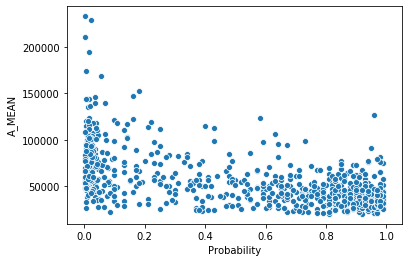

In [50]:
sns.scatterplot(df.Probability, df.A_MEAN)

In [63]:
# Test normality of wage
stat_wage, p_wage = normaltest(df.A_MEAN)
print('wage is normally distributed') if p_wage < 0.01 else print('wage is NOT normally distributed')

wage is NOT normally distributed


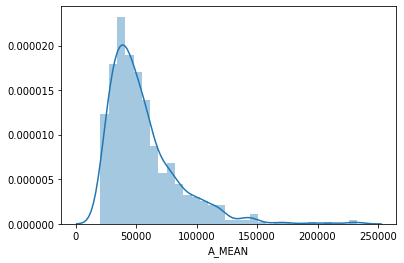

In [64]:
sns.distplot(df.A_MEAN)

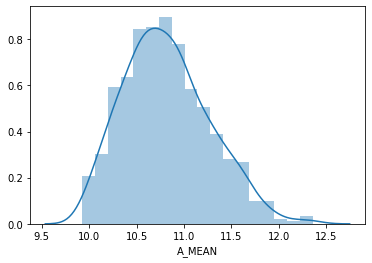

In [65]:
sns.distplot(np.log(df.A_MEAN))

# Data Analysis

In [69]:
df.A_MEAN = df.A_MEAN.apply(np.log)

In [70]:
outcome, predictors = patsy.dmatrices('Probability ~ A_MEAN', df)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Probability   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     338.4
Date:                Sun, 24 May 2020   Prob (F-statistic):           1.10e-61
Time:                        16:26:33   Log-Likelihood:                -150.52
No. Observations:                 685   AIC:                             305.0
Df Residuals:                     683   BIC:                             314.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6114      0.276     20.338      0.0